# Training Code for GAN

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/ai_in_wireless`


In [2]:
using Flux
using CUDA
using cuDNN
using Statistics
using Plots
using Random
using Serialization: deserialize
using HDF5
using H5Zblosc
using MLUtils
using ProgressMeter: @showprogress
using GPUArrays
using BFloat16s

CUDA.allowscalar(false)

Threads.nthreads()

12

In [3]:
const DEFAULT_FREQ = 2.4f0 # GHz
const PIXELS_PER_METER = 3.0f0

include("map.jl")
include("signals.jl")
include("dataset.jl")

denormalize_y (generic function with 1 method)

In [4]:
Random.seed!(1729) # Ramanujan's Taxicab Number
CUDA.seed!(1729)
device = gpu_device()

(::CUDADevice{Nothing, Missing}) (generic function with 1 method)

## Dataset
We load the dataset using deserialize.

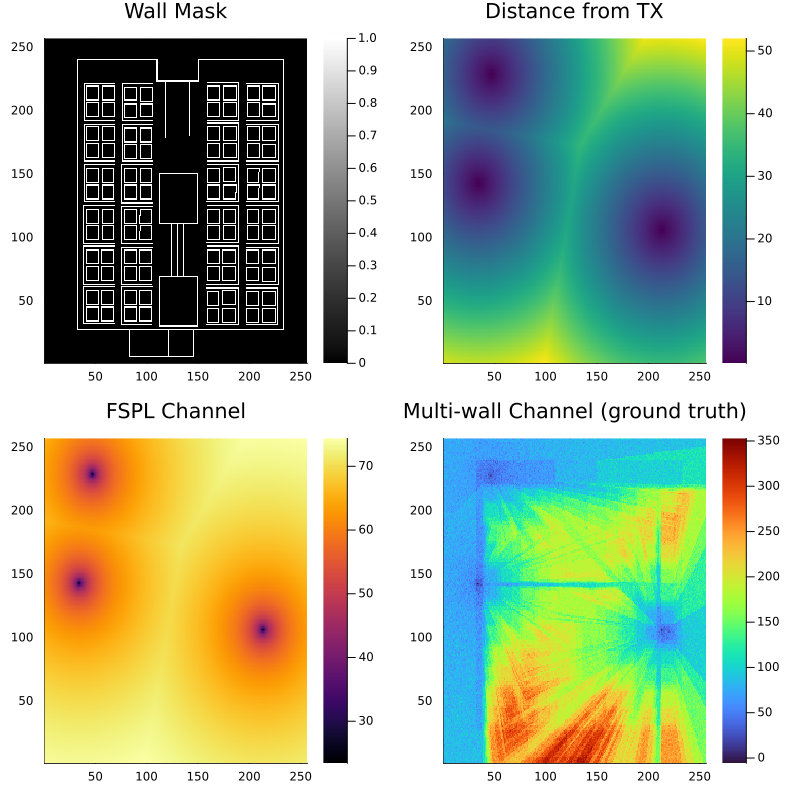

In [5]:
trainset = LazyHDF5Dataset("dataset/train.h5")
X, y = trainset[3]
p1 = heatmap(X[:, :, 1]', title="Wall Mask", c=:greys)
p2 = heatmap(X[:, :, 2]', title="Distance from TX", c=:viridis)
p3 = heatmap(X[:, :, 3]', title="FSPL Channel", c=:inferno)
p4 = heatmap(y[:, :, 1]', title="Multi-wall Channel (ground truth)", c=:turbo)
plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 800))

### Normalize

We need to normalize the dataset because the TX distance map has values greater than 1.0. The max distance in a 128x128 room is $\sqrt{2\cdot(128^2)} \approx 181$

In [6]:
X_min, X_max, y_min, y_max = calculate_stats(trainset)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


(Float32[0.0, 0.002984683, 20.054226], Float32[1.0, 97.42916, 79.828], -8.131285f0, 487.61362f0)

In [7]:
X_norm, y_norm = normalize_data(X, y, X_min, X_max, y_min, y_max);

### Discriminator

Our discriminator is [PatchGAN](https://arxiv.org/abs/1611.07004)

Input channels are: $(\text{Wall}, \text{TX Distance}, \text{TX } 1, \text{TX } 2, \text{TX } 3)$

| Layer | Input | Details | Output |
|-------|-------|---------|--------|
| Input | 256x256x4 | - | - |
| Block 1 | 256x256x4 | 4x4 kernel, stride 2, pad 1 | 64x64x64 |
| Block 2 | 64x64x64 | 4x4 kernel, stride 2, pad 1 | 32x32x128 |
| Block 3 | 32x32x128 | 4x4 kernel, stride 2, pad 1 | 16x16x256 | 
| Block 4 | 16x16x256 | 4x4 kernel, stride 1, pad 1 | 15x15x512 | 
| Output | 15x15x512 | 4x4 kernel, stride 1, pad 1 | 14x14x1 |

In [8]:
gan_leakyrelu(x) = leakyrelu(x, 0.2f0)

function PatchGAN()
    return Chain(
        # BLOCK 1 (256, 256, 4, batch) -> (128, 128, 64, batch)
        Conv((4, 4), 4 => 64, stride=2, pad=1),
        gan_leakyrelu,

        # Block 2 )(128, 128, 64, batch) -> (64, 64, 128, batc)
        Conv((4, 4), 64 => 128, stride=2, pad=1),
        BatchNorm(128),
        gan_leakyrelu,

        # Block 3 (64, 64, 128, batch) -> (32, 32, 256, batch)
        Conv((4, 4), 128 => 256, stride=2, pad=1),
        BatchNorm(256),
        gan_leakyrelu,

        # Block 4 (32, 32, 256) -> (31, 31, 512)
        Conv((4, 4), 256 => 512, stride=1, pad=1),
        BatchNorm(512),
        gan_leakyrelu,
        
        # Output (31, 31, 512, batch) -> (30, 30, 1)
        Conv((4, 4), 512 => 1, stride=1, pad=1),
    ) 
end

patchgan = PatchGAN() |> gpu

Chain(
  Conv((4, 4), 4 => 64, pad=1, stride=2),  # 4_160 parameters
  Main.gan_leakyrelu,
  Conv((4, 4), 64 => 128, pad=1, stride=2),  # 131_200 parameters
  BatchNorm(128),                       # 256 parameters, plus 256
  Main.gan_leakyrelu,
  Conv((4, 4), 128 => 256, pad=1, stride=2),  # 524_544 parameters
  BatchNorm(256),                       # 512 parameters, plus 512
  Main.gan_leakyrelu,
  Conv((4, 4), 256 => 512, pad=1),      # 2_097_664 parameters
  BatchNorm(512),                       # 1_024 parameters, plus 1_024
  Main.gan_leakyrelu,
  Conv((4, 4), 512 => 1, pad=1),        # 8_193 parameters
)         # Total: 16 trainable arrays, 2_767_553 parameters,
          # plus 6 non-trainable, 1_792 parameters, summarysize 3.867 KiB.

In [9]:
# Include wall and TX information
X, y = trainset[1:6]
X_norm, y_norm = normalize_data(X, y, X_min, X_max, y_min, y_max) |> gpu
sample_input = cat(X_norm, y_norm, dims=3)
sample_y = patchgan(sample_input)
selectdim(sample_y, 4, 1)

30×30×1 CuArray{Float32, 3, CUDA.DeviceMemory}:
[:, :, 1] =
 0.00910141  0.00678897  0.0116223  …  0.0286237   0.0272848   0.00026446
 0.0225277   0.0232204   0.0268162     0.0428775   0.0476479   0.0123201
 0.0357401   0.0286226   0.0277062     0.0562861   0.0527086   0.0110739
 0.0335654   0.0303007   0.0322996     0.0504515   0.0385162   0.00228179
 0.0388334   0.0223235   0.030384      0.0519073   0.0423312   0.00539385
 0.0287744   0.0211952   0.0292444  …  0.0550393   0.0372176   0.00144799
 0.0402315   0.0293735   0.0290056     0.0371499   0.0303535   0.00207716
 0.0386351   0.0156251   0.0180794     0.0418636   0.0360309   0.00406645
 0.0398213   0.0258666   0.0319209     0.0243697   0.0339032   0.00566493
 0.0444881   0.0309555   0.0467104     0.0252816   0.0323738   0.00253585
 0.041798    0.0315559   0.0401032  …  0.0226943   0.0260582   0.0013832
 0.0400057   0.030662    0.033492      0.0225174   0.0304677   0.00500841
 0.0488745   0.0365047   0.0380498     0.0167294   0.02

### Generator (U-Net)

We make use of U-Net Generator code.

The table assumes the standard 256x256 grid size.

Input: (Wall, TX Distance Map, FSPL Map)
Output: (Combined Path Loss Map)

We use a standard U-Net architecture. The arch is too long to be listed manually in Markdown here.

In [10]:
# Encoder Block: Conv -> BatchNorm -> LeakyReLU
function encoderblock(in_ch, out_ch; bn=true)
    layers = []
    push!(layers, Conv((4, 4), in_ch => out_ch, stride=2, pad=1))
    if bn 
        push!(layers, BatchNorm(out_ch))
    end
    push!(layers, gan_leakyrelu)
    return Chain(layers...)
end

# Decoder Block: Transpose Conv -> BatchNorm -> ReLU 
function decoderblock(in_ch, out_ch; dropout=false)
    layers = []
    push!(layers, ConvTranspose((4, 4), in_ch => out_ch, stride=2, pad=1))
    push!(layers, BatchNorm(out_ch))
    if dropout 
        push!(layers, Dropout(0.5))
    end

    push!(layers, relu)
    return Chain(layers...)
end

struct UNet 
    # Encoder Part 
    e1 :: Chain # 256x256x3 -> 128x128x64 
    e2 :: Chain  # 128x128x64 -> 64x64x128
    e3 :: Chain  # 64x64x128 -> 32x32x256
    e4 :: Chain # 32x32x256 -> 16x16x512 
    e5 :: Chain # 16x16x512 -> 8x8x512 
    e6 :: Chain # 8x8x512 -> 4x4x512
    e7 :: Chain # 4x4x512 -> 2x2x512 
    e8 :: Chain # 2x2x512 -> 1x1x512

    # Decoder Part 
    # Input = prev decoder + skip connection (concat)
    d1 :: Chain # 512 => 512 
    d2 :: Chain # 512 + 512 (skip e7) = 1024 => 512 
    d3 :: Chain # 512 + 512 (skip e6) = 1024 => 512 
    d4 :: Chain # 512 + 512 (skip e5) = 1024 => 512 
    d5 :: Chain # 512 + 512 (skip e4) = 1024 => 256 
    d6 :: Chain # 256 + 256 (skip e3) = 512 => 128 
    d7 :: Chain # 128 + 128 (skip e2) = 256 => 64

    # Final output
    final :: Chain # 128 => 1 (a 256x256 image)
end

function UNet()
    UNet(
        # Encoder 
        # No BatchNorm on the first layer
        encoderblock(3, 64; bn=false),
        encoderblock(64, 128),
        encoderblock(128, 256),
        encoderblock(256, 512),
        encoderblock(512, 512),
        encoderblock(512, 512),
        encoderblock(512, 512),
        # Bottleneck
        encoderblock(512, 512; bn=false),

        # Decoder
        # Pix2Pix GAN adds dropout to the first few layers 
        decoderblock(512, 512; dropout=true),
        decoderblock(1024, 512; dropout=true),
        decoderblock(1024, 512; dropout=true),
        decoderblock(1024, 512),
        decoderblock(1024, 256),
        decoderblock(512, 128),
        decoderblock(256, 64),

        # Final Layer maps to Sigmoid
        Chain(
            ConvTranspose((4, 4), 128 => 1, stride=2, pad=1),
            sigmoid,
        )
    )
end

Flux.@layer UNet

function (m::UNet)(x)
    # Encoder 
    x1 = m.e1(x)
    x2 = m.e2(x1)
    x3 = m.e3(x2)
    x4 = m.e4(x3)
    x5 = m.e5(x4)
    x6 = m.e6(x5)
    x7 = m.e7(x6)
    x8 = m.e8(x7)

    # Decoder with skip connections 
    # Cat along dim 3 (channels)
    y1 = m.d1(x8)
    y1_cat = cat(y1, x7, dims=3)

    y2 = m.d2(y1_cat)
    y2_cat = cat(y2, x6, dims=3)

    y3 = m.d3(y2_cat)
    y3_cat = cat(y3, x5, dims=3)

    y4 = m.d4(y3_cat)
    y4_cat = cat(y4, x4, dims=3)

    y5 = m.d5(y4_cat)
    y5_cat = cat(y5, x3, dims=3)

    y6 = m.d6(y5_cat)
    y6_cat = cat(y6, x2, dims=3)

    y7 = m.d7(y6_cat)
    y7_cat = cat(y7, x1, dims=3)

    return m.final(y7_cat)
end

In [11]:
gen = UNet() |> gpu
pred_y = gen(X_norm)

256×256×1×6 CuArray{Float32, 4, CUDA.DeviceMemory}:
[:, :, 1, 1] =
 0.496858  0.500994  0.501609  0.506108  …  0.515993  0.499402  0.501325
 0.49541   0.495795  0.499606  0.499743     0.501763  0.507412  0.514347
 0.481309  0.486972  0.487024  0.487245     0.496749  0.494967  0.496803
 0.492807  0.500414  0.502571  0.50547      0.502519  0.519328  0.513907
 0.487141  0.477245  0.493233  0.482734     0.488623  0.506164  0.498967
 0.492496  0.500059  0.501706  0.505724  …  0.501296  0.514956  0.514828
 0.485571  0.480263  0.493853  0.478955     0.487295  0.504677  0.498265
 0.492795  0.500635  0.502529  0.505266     0.502969  0.518591  0.513511
 0.487668  0.477889  0.492981  0.482869     0.487925  0.505409  0.49975
 0.49283   0.500149  0.501922  0.50608      0.50185   0.515239  0.514632
 0.485573  0.480871  0.494128  0.479376  …  0.486861  0.504503  0.498111
 0.492623  0.500551  0.502758  0.505012     0.503149  0.518059  0.513475
 0.487738  0.478058  0.492913  0.4828       0.487651  0.50

### Training Code

In [12]:
using Statistics: mean 
using BSON: @save
import ProgressMeter
using ProgressMeter: Progress, next!
using JLD2: jldsave

ProgressMeter.ijulia_behavior(:clear)

false

#### Hyperparameters

In [13]:
const λ_L1 = 100.0f0 # Weight for L1 pixel-wise Loss 

100.0f0

The discriminator loss measures how well the $D$ distinguishes real ($y$) from fake ($G(x)$)


In [14]:
function discriminator_loss(D, G, X, y)
    # Concatenate input + real output
    X_real = cat(X, y; dims=3)
    y_real = D(X_real)

    # Concatenate input + fake output 
    fake_img = G(X)
    X_fake = cat(X, fake_img; dims=3)
    y_fake = D(X_fake)

    # Real is 1, fake is 0
    loss_real = Flux.logitbinarycrossentropy(y_real, 1.0f0)
    loss_fake = Flux.logitbinarycrossentropy(y_fake, 0.0f0)
    return (loss_real + loss_fake) * 0.5f0
end

discriminator_loss (generic function with 1 method)

The generator loss measures how well G fools D + how close pixels are to the ground truth

In [15]:
function generator_loss(D, G, X, y)
    fake_img = G(X)
    X_fake = cat(X, fake_img; dims=3)
    y_fake = D(X_fake)

    # Trick the discriminator
    loss_adv = Flux.logitbinarycrossentropy(y_fake, 1.0f0)

    # Pixel-level distance between generated and ground truth
    loss_l1 = Flux.mae(fake_img, y)

    return loss_adv + (λ_L1 * loss_l1)
end

generator_loss (generic function with 1 method)

In [16]:
function train_step!(G, D, opt_g, opt_d, trainloader, X_min, X_max, y_min, y_max)
    Flux.trainmode!(G)
    Flux.trainmode!(D)
    
    total_g_loss = 0.0f0
    total_d_loss = 0.0f0
    n_batches = length(trainloader)

    for (Xs, ys) ∈ trainloader
        # Preprocessing
        Xs, ys = normalize_data(Xs, ys, X_min, X_max, y_min, y_max)
        ys = minimum(ys; dims=3)
        Xs, ys = Xs |> gpu, ys |> gpu

        # Discriminator Update
        d_loss, d_grads = Flux.withgradient(D) do d_model
            discriminator_loss(d_model, G, Xs, ys)
        end
        Flux.update!(opt_d, D, d_grads[1])

        # Generator Update 
        g_loss, g_grads = Flux.withgradient(G) do g_model 
            generator_loss(D, g_model, Xs, ys)
        end
        Flux.update!(opt_g, G, g_grads[1])

        total_g_loss += g_loss
        total_d_loss += d_loss 
    end

    return total_g_loss / n_batches, total_d_loss / n_batches
end

function validate(G, valloader, X_min, X_max, y_min, y_max)
    Flux.testmode!(G)
    val_accum = 0.0f0
    
    for (Xs, ys) in valloader
        Xs, ys = normalize_data(Xs, ys, X_min, X_max, y_min, y_max)
        ys = minimum(ys; dims=3)
        Xs, ys = Xs |> gpu, ys |> gpu

        val_accum += Flux.mae(G(Xs), ys)
    end
    
    return val_accum / length(valloader)
end

function train_gan!(G, D, trainloader, valloader, epochs; save_path="models/", min_delta=0.001f0)
    opt_g = Flux.setup(Flux.Adam(0.0002, (0.5, 0.999)), G) |> gpu 
    opt_d = Flux.setup(Flux.Adam(0.0002, (0.5, 0.999)), D) |> gpu
    G, D = G |> gpu, D |> gpu 

    g_loss_history, d_loss_history, val_loss_history = Float32[], Float32[], Float32[]
    patience, patience_counter, best_val_loss = 10, 0, Inf32

    for epoch in 1:epochs 
        avg_g, avg_d = train_step!(G, D, opt_g, opt_d, trainloader, X_min, X_max, y_min, y_max)
        avg_val_mae = validate(G, valloader, X_min, X_max, y_min, y_max)

        push!(g_loss_history, avg_g)
        push!(d_loss_history, avg_d)
        push!(val_loss_history, avg_val_mae)
        println("Epoch $epoch | Train G: $(round(avg_g, digits=4)) | Train D: $(round(avg_d, digits=4)) | Val MAE: $(round(avg_val_mae, digits=5))")

        if avg_val_mae < (best_val_loss - min_delta)
            best_val_loss = avg_val_mae
            patience_counter = 0
        else
            patience_counter += 1
            println(" -> No significant improvement for $patience_counter epochs.")
        end

        if patience_counter >= patience
            println("Early stopping at Epoch $epoch. Best Val MAE: $best_val_loss")
            break
        end

        if epoch % 5 == 0
            jldsave(joinpath(save_path, "gen_epoch_$epoch.bson"), model_state = Flux.state(cpu(G)))
        end
    end

    return (
        generator=G, 
        discriminator=D, 
        g_history=g_loss_history, 
        d_history=d_loss_history, 
        val_history=val_loss_history
    )
end

train_gan! (generic function with 1 method)

In [17]:
using Flux: DataLoader

Basic Sanity test

In [18]:
trainset = LazyHDF5Dataset("dataset/train.h5")
valset = LazyHDF5Dataset("dataset/val.h5")

subset_size = 32

trainset_sub = trainset[1:subset_size]
valset_sub = valset[1:subset_size]

trainloader_sub = DataLoader(trainset_sub, batchsize=8, shuffle=true)
valloader_sub = DataLoader(valset_sub, batchsize=8, shuffle=false)

patchgan = PatchGAN()
gen = UNet()

train_gan!(gen, patchgan, trainloader_sub, valloader_sub, 3)

Epoch 1 | Train G: 20.5968 | Train D: 0.9602 | Val MAE: 0.20042
Epoch 2 | Train G: 16.0728 | Train D: 0.7371 | Val MAE: 0.16913
Epoch 3 | Train G: 13.1413 | Train D: 0.6898 | Val MAE: 0.1372


(generator = UNet(Chain(Conv((4, 4), 3 => 64, pad=1, stride=2), gan_leakyrelu), Chain(Conv((4, 4), 64 => 128, pad=1, stride=2), BatchNorm(128, active=false), gan_leakyrelu), Chain(Conv((4, 4), 128 => 256, pad=1, stride=2), BatchNorm(256, active=false), gan_leakyrelu), Chain(Conv((4, 4), 256 => 512, pad=1, stride=2), BatchNorm(512, active=false), gan_leakyrelu), Chain(Conv((4, 4), 512 => 512, pad=1, stride=2), BatchNorm(512, active=false), gan_leakyrelu), Chain(Conv((4, 4), 512 => 512, pad=1, stride=2), BatchNorm(512, active=false), gan_leakyrelu), Chain(Conv((4, 4), 512 => 512, pad=1, stride=2), BatchNorm(512, active=false), gan_leakyrelu), Chain(Conv((4, 4), 512 => 512, pad=1, stride=2), gan_leakyrelu), Chain(ConvTranspose((4, 4), 512 => 512, pad=1, stride=2), BatchNorm(512, active=false), Dropout(0.5, active=false), relu), Chain(ConvTranspose((4, 4), 1024 => 512, pad=1, stride=2), BatchNorm(512, active=false), Dropout(0.5, active=false), relu), Chain(ConvTranspose((4, 4), 1024 => 512

Actual training. We train for 100 epochs

In [19]:
patchgan = PatchGAN()
gen = UNet()

trainset = LazyHDF5Dataset("dataset/train.h5")
valset = LazyHDF5Dataset("dataset/val.h5")

const BATCHSIZE = 8

trainloader = DataLoader(trainset, batchsize=BATCHSIZE, shuffle=true)
valloader = DataLoader(valset, batchsize=BATCHSIZE, shuffle=false)

result = train_gan!(gen, patchgan, trainloader, valloader, 25)

Epoch 1 | Train G: 4.778 | Train D: 0.6618 | Val MAE: 0.03088
Epoch 2 | Train G: 3.9041 | Train D: 0.6517 | Val MAE: 0.02793
Epoch 3 | Train G: 3.7707 | Train D: 0.6349 | Val MAE: 0.02813
 -> No significant improvement for 1 epochs.
Epoch 4 | Train G: 3.85 | Train D: 0.6274 | Val MAE: 0.02753
 -> No significant improvement for 2 epochs.
Epoch 5 | Train G: 3.6743 | Train D: 0.6387 | Val MAE: 0.02722
 -> No significant improvement for 3 epochs.
Epoch 6 | Train G: 3.5906 | Train D: 0.6477 | Val MAE: 0.02677
Epoch 7 | Train G: 3.4958 | Train D: 0.6527 | Val MAE: 0.02645
 -> No significant improvement for 1 epochs.
Epoch 8 | Train G: 3.4159 | Train D: 0.6587 | Val MAE: 0.02577
Epoch 9 | Train G: 3.3658 | Train D: 0.663 | Val MAE: 0.02539
 -> No significant improvement for 1 epochs.
Epoch 10 | Train G: 3.3161 | Train D: 0.6637 | Val MAE: 0.02495
 -> No significant improvement for 2 epochs.
Epoch 11 | Train G: 3.2781 | Train D: 0.6697 | Val MAE: 0.02465
Epoch 12 | Train G: 3.2519 | Train D: 0

(generator = UNet(Chain(Conv((4, 4), 3 => 64, pad=1, stride=2), gan_leakyrelu), Chain(Conv((4, 4), 64 => 128, pad=1, stride=2), BatchNorm(128, active=false), gan_leakyrelu), Chain(Conv((4, 4), 128 => 256, pad=1, stride=2), BatchNorm(256, active=false), gan_leakyrelu), Chain(Conv((4, 4), 256 => 512, pad=1, stride=2), BatchNorm(512, active=false), gan_leakyrelu), Chain(Conv((4, 4), 512 => 512, pad=1, stride=2), BatchNorm(512, active=false), gan_leakyrelu), Chain(Conv((4, 4), 512 => 512, pad=1, stride=2), BatchNorm(512, active=false), gan_leakyrelu), Chain(Conv((4, 4), 512 => 512, pad=1, stride=2), BatchNorm(512, active=false), gan_leakyrelu), Chain(Conv((4, 4), 512 => 512, pad=1, stride=2), gan_leakyrelu), Chain(ConvTranspose((4, 4), 512 => 512, pad=1, stride=2), BatchNorm(512, active=false), Dropout(0.5, active=false), relu), Chain(ConvTranspose((4, 4), 1024 => 512, pad=1, stride=2), BatchNorm(512, active=false), Dropout(0.5, active=false), relu), Chain(ConvTranspose((4, 4), 1024 => 512

In [27]:
gen_losses = result.g_history
discrim_losses = result.d_history
val_losses = result.val_history;

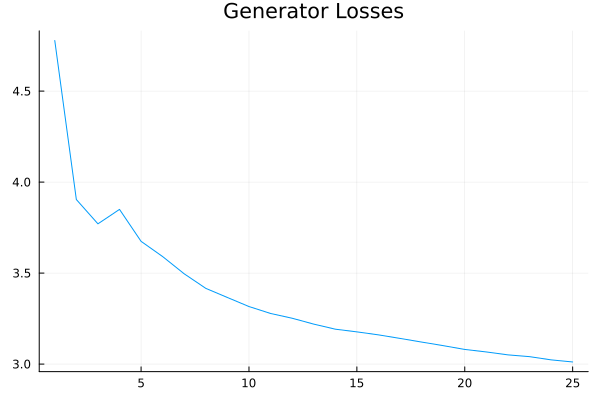

In [45]:
n_epochs = length(result.g_history)

p1 = plot(1:n_epochs, gen_losses, label=nothing, title="Generator Losses")

In [43]:
plot(1:n_epochs, discrim_losses, label=nothing, title="Discriminator Losses")

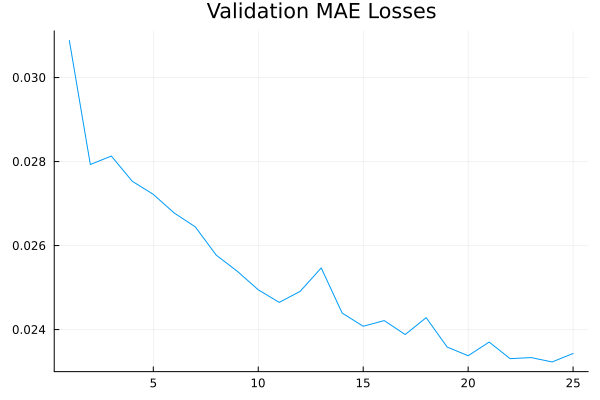

In [44]:
plot(1:n_epochs, val_losses, label=nothing, title="Validation MAE Losses")

### Test Set

In [52]:
function test_model(G, testloader, X_min, X_max, y_min, y_max)
    Flux.testmode!(G)
    
    test_errors = Float32[]

    for (Xs, ys) in testloader
        Xs, ys = normalize_data(Xs, ys, X_min, X_max, y_min, y_max)
        ys = minimum(ys; dims=3)
        Xs, ys = Xs |> gpu, ys |> gpu
    
        y_pred = G(Xs)

        batch_mae = Flux.mae(y_pred, ys)
        push!(test_errors, batch_mae)
    end
    
    avg_mae = mean(test_errors)
    std_mae = std(test_errors)

    range_val = y_max - y_min
    physical_error = avg_mae * range_val
    
    println("Average Test MAE (Normalized): $(round(avg_mae, digits=5))")
    println("Error Std Dev (Normalized): $(round(std_mae, digits=5))")
    println("Average Physical Error: $(round(physical_error, digits=2)) dB")
    
    return avg_mae, physical_error
end

test_model (generic function with 1 method)

In [53]:
testset = LazyHDF5Dataset("dataset/test.h5")
testloader = DataLoader(trainset, batchsize=BATCHSIZE, shuffle=true)

test_model(result.generator, testloader, X_min, X_max, y_min, y_max)

Average Test MAE (Normalized): 0.02238
Error Std Dev (Normalized): 0.00062
Average Physical Error: 11.09 dB


(0.0223794f0, 11.094474f0)

In [111]:
function generate_room_heatmap(G, room_input, X_min, X_max, y_min, y_max; title="Predicted Signal Power")
    X = reshape(room_input, size(room_input)..., 1)
    Xs_norm, _ = normalize_data(X, zeros(Float32, 256, 256, 1, 1), X_min, X_max, y_min, y_max)
    
    Flux.testmode!(G)
    y_pred = G(Xs_norm |> gpu) |> cpu
    hmap = dropdims(y_pred, dims=(3, 4))
    
    db_heatmap = (hmap' .* (y_max - y_min)) .+ y_min

    p = heatmap(
        db_heatmap, 
        color=:turbo, 
        title=title,
        clims=(y_min, y_max)
    )
    
    return db_heatmap, p
end

generate_room_heatmap (generic function with 1 method)

In [114]:
trainset = LazyHDF5Dataset("dataset/train.h5")

LazyHDF5Dataset(HDF5.File: (read-only) dataset/train.h5, HDF5.Dataset: /X (file: dataset/train.h5 xfer_mode: 0), HDF5.Dataset: /Y (file: dataset/train.h5 xfer_mode: 0), 10000)

In [115]:
function plot_testset(testset, idx)
    X, y = trainset[idx]

    db_heatmap, db_plot = generate_room_heatmap(result.generator, X, X_min, X_max, y_min, y_max)

    p1 = heatmap(X[:, :, 1]', title="Wall Mask", c=:greys)
    p2 = heatmap(X[:, :, 2]', title="Distance from TX", c=:viridis)
    p3 = heatmap(y[:, :, 1]', title="Multi-wall Channel (ground truth)", c=:turbo)
    plot(p1, p2, p3, db_plot, layout=(2, 2), size=(800, 800))
end

plot_testset (generic function with 1 method)

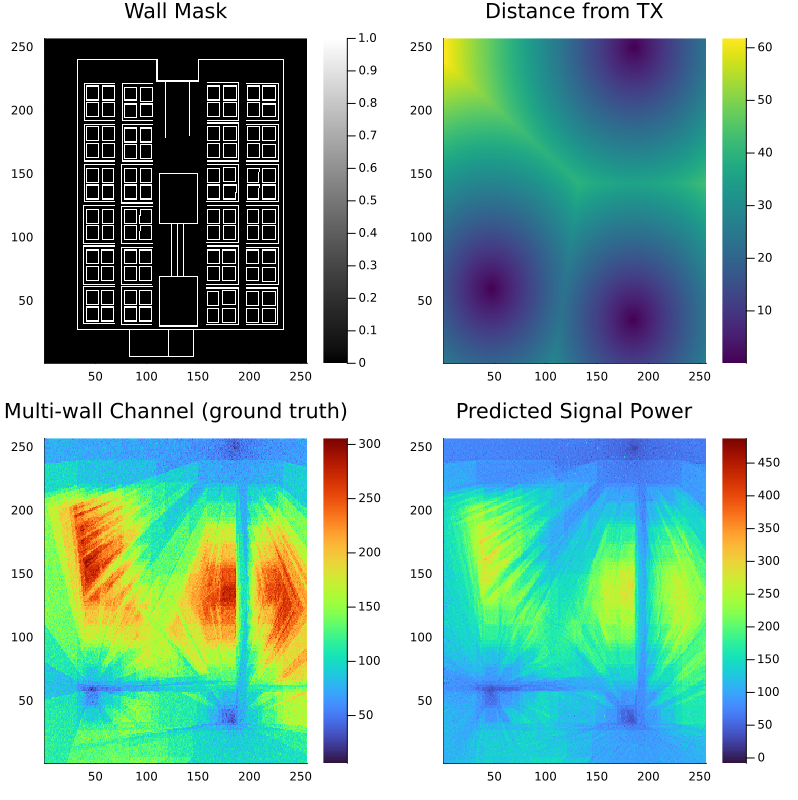

In [116]:
plot_testset(testset, 1)

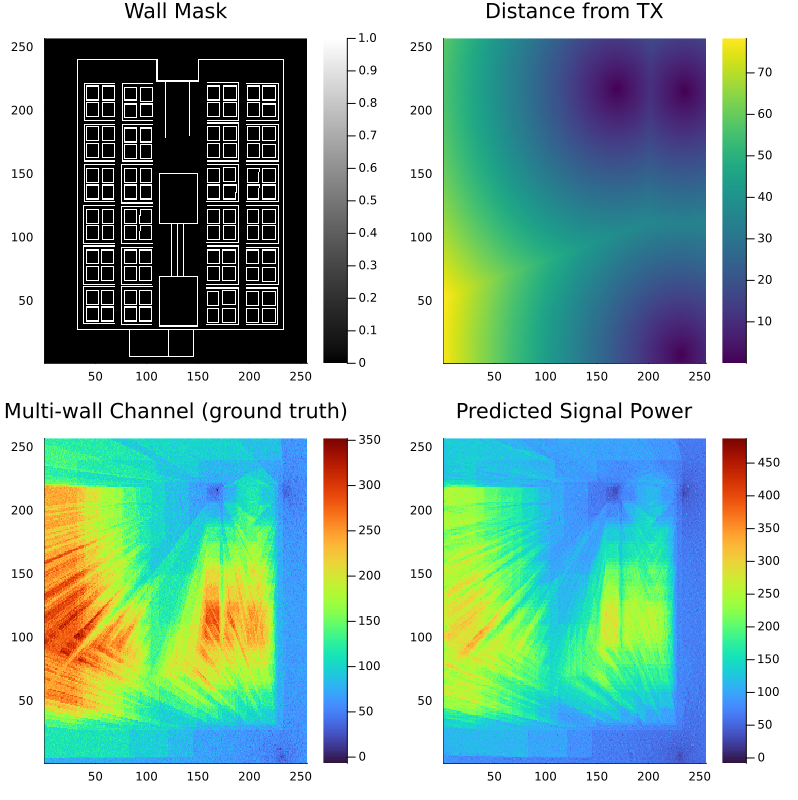

In [118]:
plot_testset(testset, 200)

In [119]:
plot_testset(testset, 329)